In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # to plot in 3d
from casadi import *
import function_lib as fn

Ts = 1/30               # sampling time in s
mass = 1.846            # mass of the vehicle in kg

sys,F = fn.quadcopter(Ts,m=mass)  #import quadcopter dynamics model

xm = 0*np.ones((12,1))              # intial condition
u_in = vertcat(mass*9.81,0,0,0)     # initial steady-state input
target = vertcat(3,2,1)             # initial target

lbx = -inf*np.ones((12,1))          # state lower bounds
ubx = inf*np.ones((12,1))           # state upper bounds
dx0 = 0*np.ones((12,1))             # state initial guess

lbu = -inf*np.ones((4,1))           # input lower bounds
ubu = inf*np.ones((4,1))            # input upper bounds
u0 = vertcat(9.81*1.846,0*np.ones((3,1))) # input initial guess

par = {'lbx':lbx,'ubx':ubx,'dx0':dx0,'lbu':lbu,'ubu':ubu,'u0':u0}

OCP, trajectories = fn.buildNLP(sys,par,N=20,tf=Ts)     # build OCP
solver = OCP['solver']

#xm = fn.solveODE(sys,u_in,target) 
#sol,flag = fn.SS_opt(sys,target)
#xoptSS = sol['x'].full()


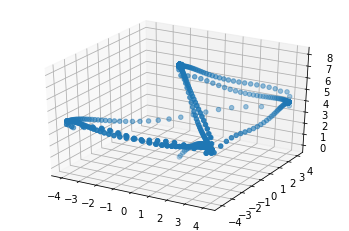

In [50]:
# Drone 1, that randomly visits target points A, B, C, D and E (e.g. pick up items from different stations)

def target_selector(i):
    switcher={
        1:vertcat(4,4,4),
        2:vertcat(4,-4,4),
        3:vertcat(-4,-4,4),
        4:vertcat(-4,4,4)
        }
    return switcher.get(i,vertcat(0,0,8))

simTime = 60  # simulation time in s
x = []
p = []
u = []
for i in range(0,int(simTime/Ts)):
    
    if i%(np.random.randint(3,7)/Ts) == 0:
        target = target_selector(np.random.randint(0,4))
        
    sol = solver(x0 = OCP['x0'],
                lbx = OCP['lbx'],
                ubx = OCP['ubx'],
                lbg = OCP['lbg'],
                ubg = OCP['ubg'],
                p = vertcat(xm,u_in,target))
    
    #assert solver.stats()['return_status']=='Solve_Succeeded', solver.stats()['return_status'] 

    # Extract the optimal solutions
    [wopt, uopt] = trajectories(sol['x'])
    xopt = wopt[3,:].full().reshape(-1,1)
    yopt = wopt[4,:].full().reshape(-1,1)
    zopt = wopt[5,:].full().reshape(-1,1)
    frce = uopt[0,:].full().reshape(-1,1)
    tauR = uopt[1,:].full().reshape(-1,1)
    tauP = uopt[2,:].full().reshape(-1,1)
    tauY = uopt[3,:].full().reshape(-1,1)

    # extract first control action
    u_in = vertcat(frce[0],tauR[0],tauP[0],tauY[0])

    Fk = F(x0=xm,p=vertcat(u_in,target))
    xm =  Fk['xf']
    
    x = horzcat(x,xm.full())
    p = horzcat(p,target)
    u = horzcat(u,u_in)

#plot position of vehicle
xt = np.array(reshape(x[3,:],-1,1))
yt = np.array(reshape(x[4,:],-1,1))
zt = np.array(reshape(x[5,:],-1,1))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xt, yt, zt, label='trajectory')

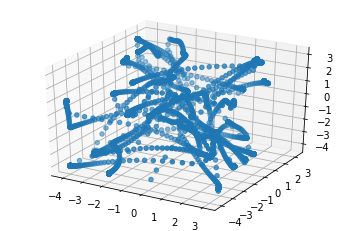

In [54]:
# Drone 2, that has a random walk

simTime = 3*60  # simulation time in s
x = []
p = []
u = []
for i in range(0,int(simTime/Ts)):
    
    if i%(np.random.randint(3,7)/Ts) == 0:
        target = vertcat(np.random.randint(-4,4),np.random.randint(-4,4),np.random.randint(-4,4))

    if i == 0:
        sol['x'] = OCP['x0']
        
    sol = solver(x0 = sol['x'],
                lbx = OCP['lbx'],
                ubx = OCP['ubx'],
                lbg = OCP['lbg'],
                ubg = OCP['ubg'],
                p = vertcat(xm,u_in,target))
    
    #assert solver.stats()['return_status']=='Solve_Succeeded', solver.stats()['return_status'] 

    # Extract the optimal solutions
    [wopt, uopt] = trajectories(sol['x'])
    xopt = wopt[3,:].full().reshape(-1,1)
    yopt = wopt[4,:].full().reshape(-1,1)
    zopt = wopt[5,:].full().reshape(-1,1)
    frce = uopt[0,:].full().reshape(-1,1)
    tauR = uopt[1,:].full().reshape(-1,1)
    tauP = uopt[2,:].full().reshape(-1,1)
    tauY = uopt[3,:].full().reshape(-1,1)

    # extract first control action
    u_in = vertcat(frce[0],tauR[0],tauP[0],tauY[0])

    Fk = F(x0=xm,p=vertcat(u_in,target))
    xm =  Fk['xf']
    
    x = horzcat(x,xm.full())
    p = horzcat(p,target)
    u = horzcat(u,u_in)

#plot position of vehicle
xt = np.array(reshape(x[3,:],-1,1))
yt = np.array(reshape(x[4,:],-1,1))
zt = np.array(reshape(x[5,:],-1,1))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xt, yt, zt, label='trajectory')

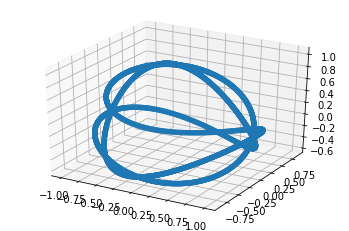

In [43]:
# Drone 3, that has a spherical path

simTime = 2*60  # simulation time in s
x = []
p = []
u = []
theta = 0
phi = 0
for i in range(0,int(simTime/Ts)):
    
    theta = theta + 0.3
    phi = phi + 0.1
    target = vertcat(sin(theta*np.pi/180),cos(theta*np.pi/180)*sin(phi*np.pi/180),cos(theta*np.pi/180)*cos(phi*np.pi/180))

    if i == 0:
        sol['x'] = OCP['x0']

    sol = solver(x0 = sol['x'],
                lbx = OCP['lbx'],
                ubx = OCP['ubx'],
                lbg = OCP['lbg'],
                ubg = OCP['ubg'],
                p = vertcat(xm,u_in,target))
    
    #assert solver.stats()['return_status']=='Solve_Succeeded', solver.stats()['return_status'] 

    # Extract the optimal solutions
    [wopt, uopt] = trajectories(sol['x'])
    xopt = wopt[3,:].full().reshape(-1,1)
    yopt = wopt[4,:].full().reshape(-1,1)
    zopt = wopt[5,:].full().reshape(-1,1)
    frce = uopt[0,:].full().reshape(-1,1)
    tauR = uopt[1,:].full().reshape(-1,1)
    tauP = uopt[2,:].full().reshape(-1,1)
    tauY = uopt[3,:].full().reshape(-1,1)

    # extract first control action
    u_in = vertcat(frce[0],tauR[0],tauP[0],tauY[0])

    Fk = F(x0=xm,p=vertcat(u_in,target))
    xm =  Fk['xf']
    
    x = horzcat(x,xm.full())
    p = horzcat(p,target)
    u = horzcat(u,u_in)

#plot position of vehicle
xt = np.array(reshape(x[3,:],-1,1))
yt = np.array(reshape(x[4,:],-1,1))
zt = np.array(reshape(x[5,:],-1,1))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xt, yt, zt, label='trajectory')


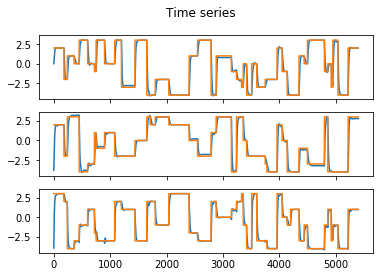

In [55]:

# time series plot 
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Time series')
axs[0].plot(xt)
axs[0].plot(p[0,:].full().reshape(-1,1),label='x')

axs[1].plot(yt)
axs[1].plot(p[1,:].full().reshape(-1,1))

axs[2].plot(zt)
axs[2].plot(p[2,:].full().reshape(-1,1))


In [56]:
# save data to csv file
x = np.array(x)
p = np.array(p)
u = np.array(u)
data  = np.transpose(np.vstack((x,p,u)))
np.savetxt('drone2.csv', data, delimiter=',')
